In [6]:
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from pathlib import Path, PurePath
import csv
import pandas as pd
import numpy as np
import scipy.stats as stats
import pickle
from joblib import Parallel, delayed, dump, load
from shutil import rmtree
from collections import defaultdict

import timeit

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import ParameterGrid, ParameterSampler
from sklearn.feature_selection import RFECV

from sklearn.base import clone

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import catboost as cb
from catboost import CatBoostClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm

In [7]:
rlist = []
records = PurePath(Path(os.getcwd()).parents[1], Path('/Users/taran/Documents/GitHub/2022-svsm-afib-group1/mit-bih-dataframes-stepping/subject_list.csv'))
with open(records) as rfile:
    recordreader = csv.reader(rfile, delimiter=' ', quotechar='|')
    for row in recordreader:
        rlist.append(row[0])

In [8]:
current_weight = 0.5

In [9]:
feature_dfs = {}
for record in tqdm(rlist):
    feature_dfs[record] = pd.read_parquet(str(Path(os.getcwd()).parents[1]) + '/GitHub/2022-svsm-afib-group1/mit-bih-time-features-stepping/'+record+'.parquet')

combined_features = pd.concat([feature_dfs[key][1:] for key in feature_dfs])

  0%|          | 0/23 [00:00<?, ?it/s]

In [10]:
X = combined_features[['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS', 'LtoR', 'LtoL', 'std', 'cov', 'range', 'rrInt_var', 'rmean_var', 'rmssd', 'mad', 'iqr','entropy','approx_entropy']]#, 'drrmean', 'drrvar']]
y = combined_features['mappedLabel'].map({"Non-Afib": 0, "Afib": 1})
groups = combined_features['subjectID'].astype('int64')

logo = LeaveOneGroupOut()
splits = list(logo.split(X, y, groups=groups))

In [11]:
np.seterr(all='ignore')
moving_accs = []

if os.path.exists(f'saved_results_stepping_{current_weight}')==False:
    os.mkdir(f'saved_results_stepping_{current_weight}')

In [12]:
def score_reporter(results, importances=True, moving_acc_plot=False, classifier_name="idk"):
    bestParams = None
    maxScore = 0
    for params, scores in results.items():
        num_splits = scores['folds']
        accuracy = [scores[f"split{i}_accuracy"] for i in range(num_splits)]
        print(params, np.mean(accuracy))
        
        if (np.mean(accuracy) > maxScore):
            bestParams = params
            maxScore = np.mean(accuracy)
            
    bestScores = results[bestParams]
    num_splits = bestScores['folds']
    accuracy = [bestScores[f"split{i}_accuracy"] for i in range(num_splits)]
    sensitivity = [bestScores[f"split{i}_sensitivity"] for i in range(num_splits)]
    specificity = [bestScores[f"split{i}_specificity"] for i in range(num_splits)]
    precision = [bestScores[f"split{i}_precision"] for i in range(num_splits)]
    f1_score = [bestScores[f"split{i}_f1_score"] for i in range(num_splits)]
    if importances:
        feature_importances = [list(bestScores[f"split{i}_feature_importances"].values()) for i in range(num_splits)]
    
        avg_importances = np.mean(np.array(feature_importances), axis=0)
        feature_names = list(bestScores["split0_feature_importances"].keys())[0]
        mapped_importances = {name: rank for name, rank in zip(feature_names, avg_importances.flatten())}
        
    if moving_acc_plot:
        subject_accs = [bestScores[f"split{i}_subject_acc"] for i in range(num_splits)]
        minLen = len(subject_accs[0])
        for accs in subject_accs:
            if len(accs)<minLen:
                minLen = len(accs)

        avg_list = [sum(sub_list) * 100 / len(sub_list) for sub_list in zip(*subject_accs)]
        plt.plot(avg_list)
        plt.title(classifier_name + " Accuracy Over Time")
        plt.xlabel("Stepping windows elapsed")
        plt.ylabel("Average accuracy across CV folds (%)")
        plt.show()
    
    print(f"The best parameters were {bestParams}")
    print(f"Accuracy for each fold: {accuracy}")
    print(f"Mean accuracy: {np.nanmean(accuracy)}")
    print(f"Std accuracy: {np.nanstd(accuracy)}")
    print(f"Sensitivity for each fold: {sensitivity}")
    print(f"Mean sensitivity: {np.nanmean(sensitivity)}")
    print(f"Std sensitivity: {np.nanstd(sensitivity)}")
    print(f"Specificity for each fold: {specificity}")
    print(f"Mean specificity: {np.nanmean(specificity)}")
    print(f"Std specificity: {np.nanstd(specificity)}")
    print(f"Precision for each fold: {precision}")
    print(f"Mean precision: {np.nanmean(precision)}")
    print(f"Std precision: {np.nanstd(precision)}")
    print(f"F1-score for each fold: {f1_score}")
    print(f"Mean F1-score: {np.nanmean(f1_score)}")
    print(f"Std F1-score: {np.nanstd(f1_score)}")
    if importances:
        print("Average feature importances: ")
        print(mapped_importances)

In [13]:
def fit_parallel(clf, X, y, train, test, **fit_params):
    np.seterr(all='ignore')
    
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    cloned_clf = clone(clf)
    cloned_clf.fit(X_train, y_train)

    pred_values = cloned_clf.predict(X_test)
    
    total_seen = 0
    total_correct = 0
    subject_acc = []
    for idx, pred in enumerate(pred_values):
        total_seen+=1
        if pred==y_test.iloc[idx]:
            total_correct+=1
        subject_acc.append(total_correct/total_seen)

    cm = confusion_matrix(y_test.values.reshape(y_test.shape[0]), pred_values)
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    specificity = cm[1][1]/(cm[1][0]+cm[1][1])
    precision = (cm[0][0])/(cm[0][0]+cm[1][0])

    results_dict = {
        "accuracy": accuracy_score(y_test, pred_values),
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "f1_score": (2*precision*sensitivity)/(precision+sensitivity),
        "subject_acc": subject_acc
    }
    
    return results_dict

In [14]:
def fit_xgboost_parallel(clf, X, y, train, test, **fit_params):
    np.seterr(all='ignore')
    
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    cloned_clf = clone(clf)
    cloned_clf.fit(X_train, y_train)

    pred_values = cloned_clf.predict(X_test)
    
    total_seen = 0
    total_correct = 0
    subject_acc = []
    for idx, pred in enumerate(pred_values):
        total_seen+=1
        if pred==y_test.iloc[idx]:
            total_correct+=1
        subject_acc.append(total_correct/total_seen)

    cm = confusion_matrix(y_test.values.reshape(y_test.shape[0]), pred_values)
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    specificity = cm[1][1]/(cm[1][0]+cm[1][1])
    precision = (cm[0][0])/(cm[0][0]+cm[1][0])

    results_dict = {
        "accuracy": accuracy_score(y_test, pred_values),
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "f1_score": (2*precision*sensitivity)/(precision+sensitivity),
        "feature_importances": {A: B for A, B in zip(cloned_clf.feature_names_in_, cloned_clf.feature_importances_)},
        "subject_acc": subject_acc
    }
    
    return results_dict

In [15]:
def fit_catboost_parallel(clf, X, y, train, test, **fit_params):
    np.seterr(all='ignore')
    
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    cloned_clf = clone(clf)
    cloned_clf.fit(X_train, y_train)

    pred_values = cloned_clf.predict(X_test)
    
    total_seen = 0
    total_correct = 0
    subject_acc = []
    for idx, pred in enumerate(pred_values):
        total_seen+=1
        if pred==y_test.iloc[idx]:
            total_correct+=1
        subject_acc.append(total_correct/total_seen)

    cm = confusion_matrix(y_test.values.reshape(y_test.shape[0]), pred_values)
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    specificity = cm[1][1]/(cm[1][0]+cm[1][1])
    precision = (cm[0][0])/(cm[0][0]+cm[1][0])

    results_dict = {
        "accuracy": accuracy_score(y_test, pred_values),
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "f1_score": (2*precision*sensitivity)/(precision+sensitivity),
        "feature_importances": {A: B for A, B in zip(cloned_clf.feature_names_, cloned_clf.feature_importances_)},
        "subject_acc": subject_acc
    }
    
    return results_dict

In [16]:
def fit_lightgbm_parallel(clf, X, y, train, test, **fit_params):
    np.seterr(all='ignore')
    
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    cloned_clf = clone(clf)
    cloned_clf.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)], 
                   eval_metric='logloss')

    pred_values = cloned_clf.predict(X_test)
    
    total_seen = 0
    total_correct = 0
    subject_acc = []
    for idx, pred in enumerate(pred_values):
        total_seen+=1
        if pred==y_test.iloc[idx]:
            total_correct+=1
        subject_acc.append(total_correct/total_seen)

    cm = confusion_matrix(y_test.values.reshape(y_test.shape[0]), pred_values)
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    specificity = cm[1][1]/(cm[1][0]+cm[1][1])
    precision = (cm[0][0])/(cm[0][0]+cm[1][0])

    results_dict = {
        "accuracy": accuracy_score(y_test, pred_values),
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "f1_score": (2*precision*sensitivity)/(precision+sensitivity),
        "feature_importances": {A: B for A, B in zip(cloned_clf.feature_name_, cloned_clf.feature_importances_)},
        "subject_acc": subject_acc
    }
    
    return results_dict

In [17]:
# Logistic regression
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "solver": ["liblinear"]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = LogisticRegression(max_iter=3000,
                                 **fit_params)
        fold_results = Parallel(n_jobs=8)(
            delayed(fit_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)
            for (train, test) in splits
        )
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_stepping_{current_weight}/lr_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

(('solver', 'liblinear'),) 0.9087707414765036


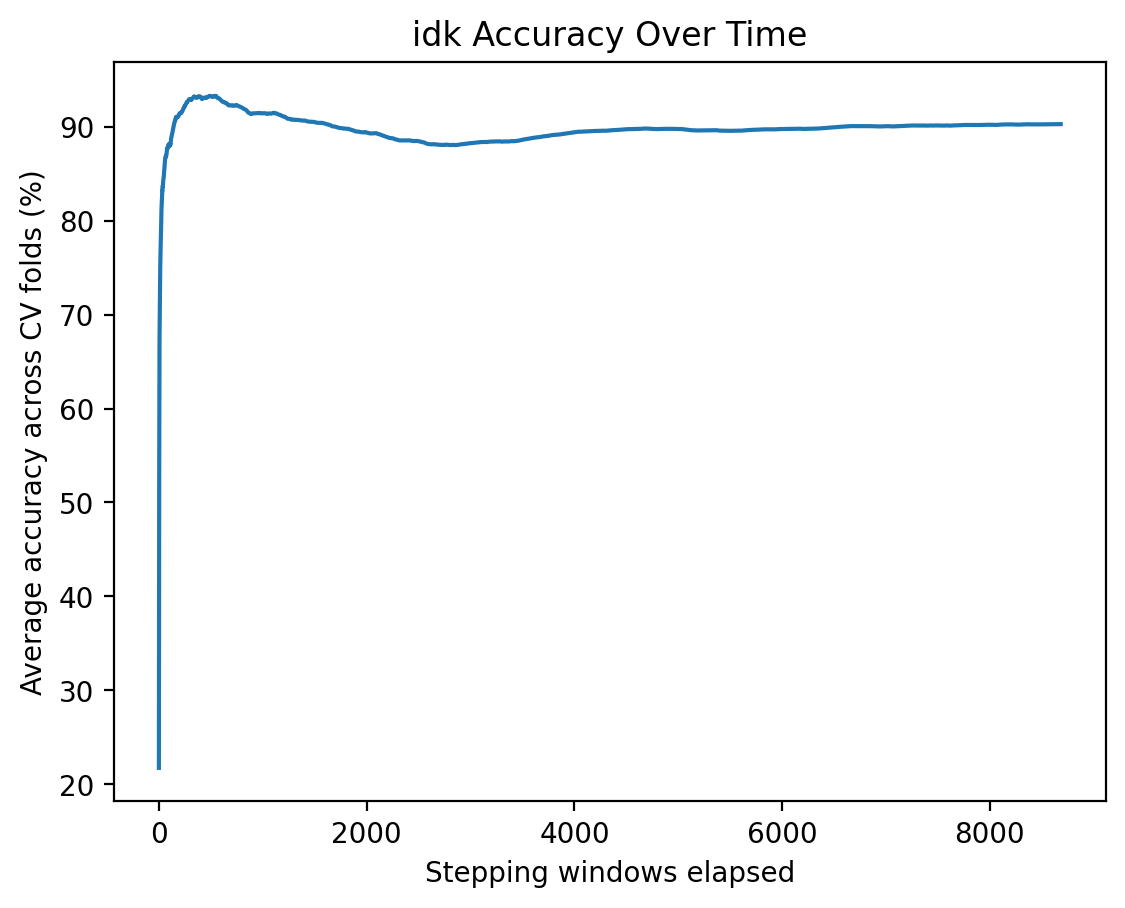

The best parameters were (('solver', 'liblinear'),)
Accuracy for each fold: [0.9032346241457859, 0.9525658448197761, 0.993269037572835, 0.8491907568528394, 0.9938876329230512, 0.9238354742441935, 0.9001120657452372, 0.9758996728462377, 0.9264705882352942, 0.9026151272343048, 0.9799433180728144, 0.9899804215133019, 0.8201423177461517, 0.791628381827463, 0.6556515957446809, 0.9794977298524404, 0.9905463339562494, 0.9507029226785053, 0.5407177130499425, 0.9518189024927332, 0.9912173202614379, 0.9420289855072463, 0.9967702866370609]
Mean accuracy: 0.9087707414765036
Std accuracy: 0.11204838954535797
Sensitivity for each fold: [0.9024165283158089, 0.9686570967467935, 0.9948707427164547, 0.8375696202531645, 0.9978693181818182, 0.9173293215846408, 0.9302662037037037, 0.9779894875164258, 0.9204801200300075, 0.9012501124201817, 0.704, 0.99463243873979, 0.6633892423366108, nan, nan, 0.9660146699266504, 0.9912221471978393, 0.9964440932437771, 0.40153065764883866, 0.976897689768977, 0.972767203513

In [18]:
score_reporter(results, False, True)

In [19]:
# LDA
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "solver": ["lsqr"]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = LinearDiscriminantAnalysis(**fit_params)
        fold_results = Parallel(n_jobs=8)(
            delayed(fit_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)
            for (train, test) in splits
        )
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_stepping_{current_weight}/lda_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

/Users/taran/opt/anaconda3/envs/afib/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


(('solver', 'lsqr'),) 0.9231179377294574


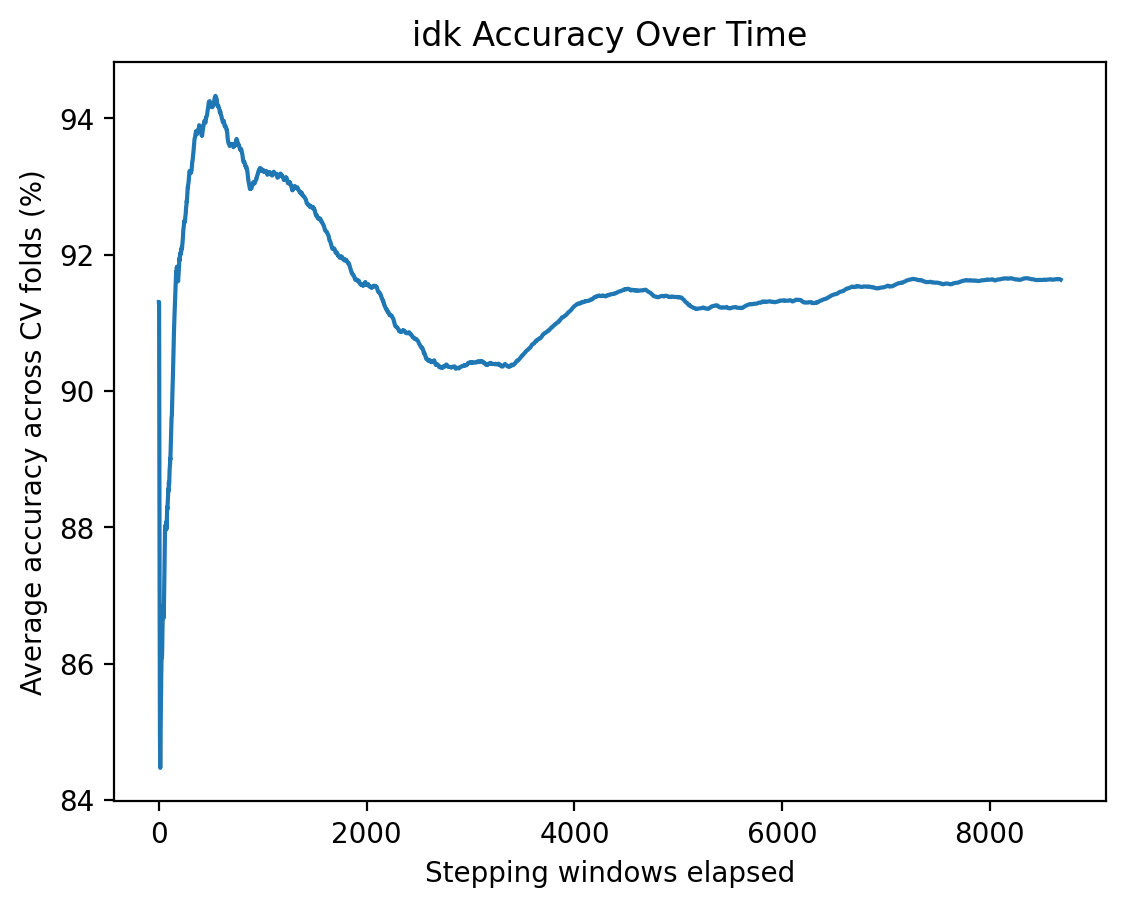

The best parameters were (('solver', 'lsqr'),)
Accuracy for each fold: [0.9107061503416857, 0.9492655147867728, 0.993771348201728, 0.8895125830292825, 0.991961818638533, 0.9440768132866225, 0.9029510646245797, 0.9912758996728462, 0.9326583092253294, 0.9107158580611077, 0.9807426785844052, 0.9909017620638029, 0.8051844321812373, 0.8856559469116896, 0.6471409574468086, 0.9716940976163451, 0.9897768495108278, 0.9742878283388827, 0.6512806649996621, 0.9641504448163482, 0.9912173202614379, 0.9666867954911433, 0.9960974296864487]
Mean accuracy: 0.9231179377294574
Std accuracy: 0.09638856824040332
Sensitivity for each fold: [0.9098874746356761, 0.9671281746368809, 0.995588838736151, 0.8814177215189873, 0.9985795454545454, 0.9407550684146428, 0.9270833333333334, 0.9929916776171704, 0.9152288072018004, 0.9095242377911683, 0.672, 0.9949824970828471, 0.6388085598611914, nan, nan, 0.9623471882640586, 0.9921674544226874, 0.9968391939944686, 0.5498798611729109, 0.9827911362564828, 0.9768667642752562

In [20]:
score_reporter(results, False, True)

In [21]:
# QDA
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "fake": ["param"]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = QuadraticDiscriminantAnalysis()
        fold_results = Parallel(n_jobs=8)(
            delayed(fit_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)
            for (train, test) in splits
        )
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_stepping_{current_weight}/qda_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

/Users/taran/opt/anaconda3/envs/afib/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/taran/opt/anaconda3/envs/afib/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/taran/opt/anaconda3/envs/afib/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/taran/opt/anaconda3/envs/afib/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/taran/opt/anaconda3/envs/afib/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/taran/opt/anaconda3/envs/afib/lib/python3.11/site-packages/sklearn/discri

(('fake', 'param'),) 0.7126257659679469


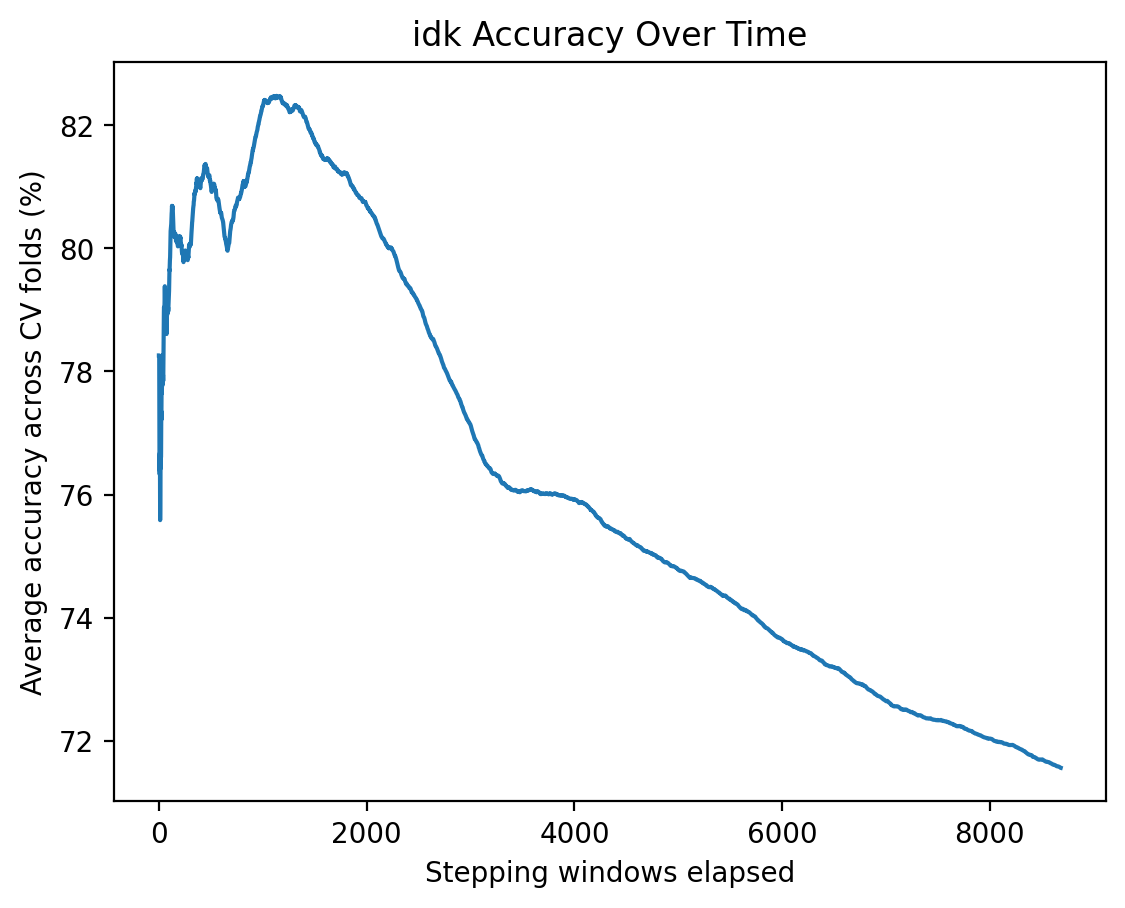

The best parameters were (('fake', 'param'),)
Accuracy for each fold: [0.9296583143507973, 0.8073513233676309, 0.9800080369700623, 0.9021423893722519, 0.7571799380390186, 0.915142078629817, 0.6837504669406052, 0.9908396946564886, 0.5694310511089682, 0.8966276305362332, 0.3880531938085895, 0.9796153403201658, 0.6068835318036596, 0.34211332312404286, 0.041622340425531916, 0.46843076049943244, 0.8822688798505002, 0.28995560488346284, 0.7764411705075354, 0.7864881529111248, 0.8854166666666666, 0.9624597423510467, 0.5485129861391468]
Mean accuracy: 0.7126257659679469
Std accuracy: 0.25624496642219213
Sensitivity for each fold: [0.9392178564840435, 0.9890427248789603, 0.9980508822322528, 0.9654683544303797, 0.9891098484848485, 0.9920481409843112, 0.9357638888888888, 0.9939772229522558, 0.9397349337334333, 0.9081751956111161, 0.868, 0.9878646441073512, 0.7599768652400232, nan, nan, 0.9770171149144254, 0.9814989871708305, 0.9952587909917029, 0.8314496751802083, 0.9760726072607261, 0.9672035139

In [22]:
score_reporter(results, False, True)

In [23]:
# KNN
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "n_neighbors": [9]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = KNeighborsClassifier(**fit_params)
        fold_results = Parallel(n_jobs=8)(
            delayed(fit_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)
            for (train, test) in splits
        )
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_stepping_{current_weight}/knn_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

/Users/taran/opt/anaconda3/envs/afib/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


(('n_neighbors', 9),) 0.8774890060102547


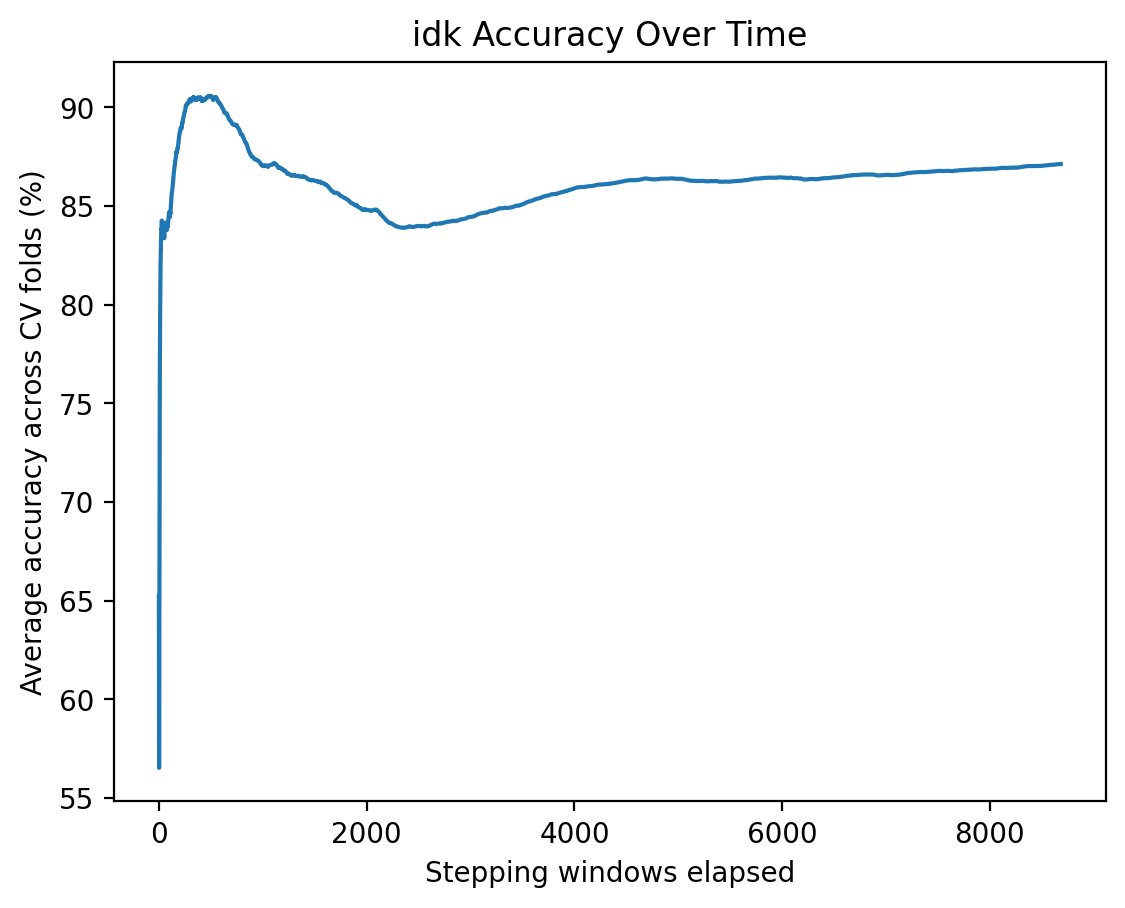

The best parameters were (('n_neighbors', 9),)
Accuracy for each fold: [0.8855580865603645, 0.9431178411958843, 0.9900542495479204, 0.7868837122275236, 0.9823327472159424, 0.9080057090956274, 0.9061636159880463, 0.9727371864776445, 0.8850048216007714, 0.772387074051246, 0.9719497129569072, 0.9563514914200161, 0.7787539936102237, 0.8006125574272588, 0.5676196808510638, 0.9803490351872872, 0.9359129383313181, 0.9100073991860895, 0.47212272757991486, 0.8849643266097067, 0.9673883442265795, 0.9395128824476651, 0.9844570044408558]
Mean accuracy: 0.8774890060102547
Std accuracy: 0.1298481953503214
Sensitivity for each fold: [0.884338682899834, 0.9509895523655822, 0.9910750923266312, 0.7700253164556962, 0.970407196969697, 0.9003510280106025, 0.8414351851851852, 0.974485326325011, 0.8754688672168042, 0.7683244896123752, 0.554, 0.958926487747958, 0.5814054366685946, nan, nan, 0.9581907090464548, 0.9278865631330182, 0.9652311339391545, 0.30648749666281033, 0.9015794436586516, 0.9686676427525622,

In [24]:
score_reporter(results, False, True)

In [25]:
# Decision tree
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "max_depth": [None]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = DecisionTreeClassifier(**fit_params)
        
        fold_results = []
        for (train, test) in tqdm(splits, leave=False):
            X_train = X.iloc[train]
            y_train = y.iloc[train]

            X_test = X.iloc[test]
            y_test = y.iloc[test]

            cloned_clf = clone(clf)
            cloned_clf.fit(X_train, y_train)

            pred_values = cloned_clf.predict(X_test)
    
            total_seen = 0
            total_correct = 0
            subject_acc = []
            for idx, pred in enumerate(pred_values):
                total_seen+=1
                if pred==y_test.iloc[idx]:
                    total_correct+=1
                subject_acc.append(total_correct/total_seen)

            cm = confusion_matrix(y_test.values.reshape(y_test.shape[0]), pred_values)
            sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
            specificity = cm[1][1]/(cm[1][0]+cm[1][1])
            precision = (cm[0][0])/(cm[0][0]+cm[1][0])

            results_dict = {
                "accuracy": accuracy_score(y_test, pred_values),
                "sensitivity": sensitivity,
                "specificity": specificity,
                "precision": precision,
                "f1_score": (2*precision*sensitivity)/(precision+sensitivity),
                "subject_acc": subject_acc
            }

            fold_results.append(results_dict)
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_stepping_{current_weight}/dt_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

(('max_depth', None),) 0.9101971881962018


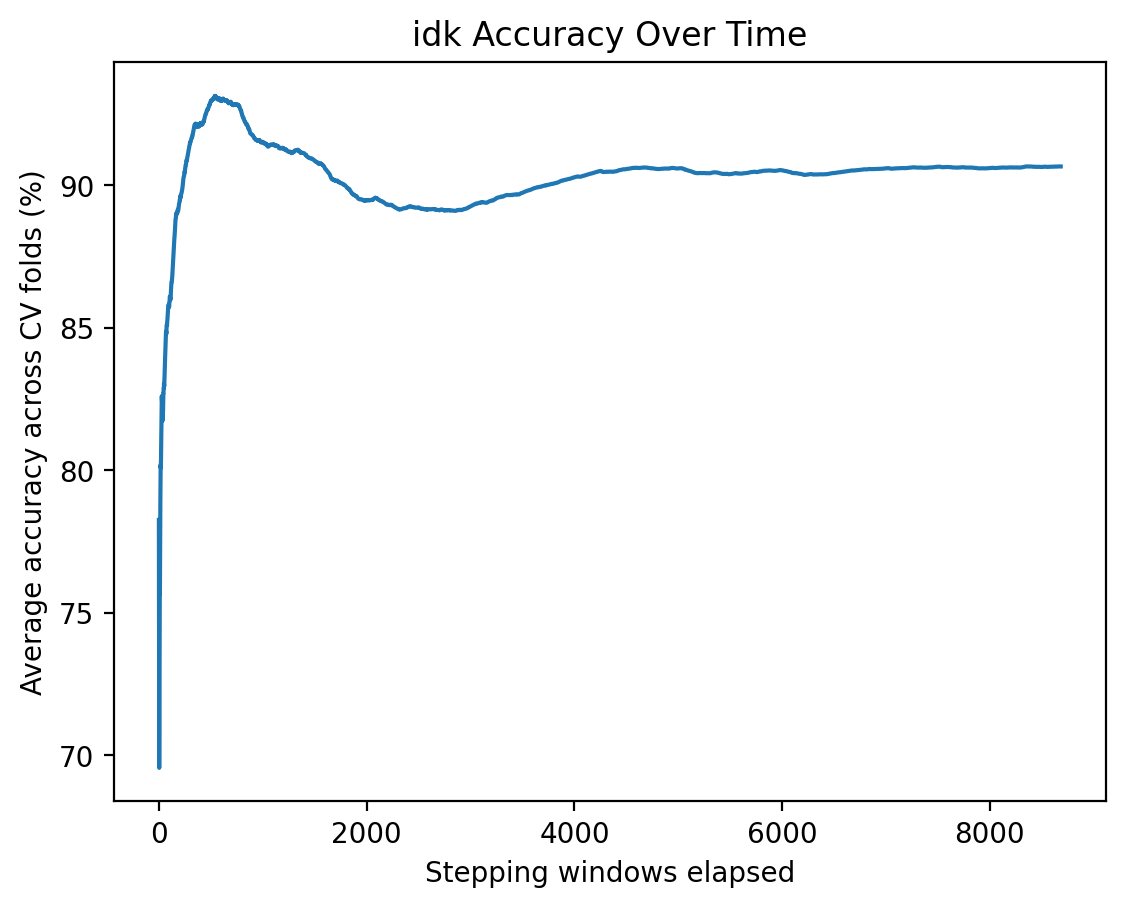

The best parameters were (('max_depth', None),)
Accuracy for each fold: [0.9133485193621868, 0.9299165210638711, 0.9906570223025919, 0.9068200954252035, 0.9771414217533283, 0.9498507850006488, 0.809114680612626, 0.9895310796074155, 0.9095146255223401, 0.9072818526019195, 0.9549451348012499, 0.9819186916964183, 0.8247168167295963, 0.8592138846350179, 0.6703457446808511, 0.9396282633371169, 0.9761459821919314, 0.9322974472807991, 0.7164290058795701, 0.9126222143926715, 0.9465550108932462, 0.9674919484702094, 0.9690485802718342]
Mean accuracy: 0.9101971881962018
Std accuracy: 0.08218843245783575
Sensitivity for each fold: [0.9131156613171002, 0.9624564681899261, 0.9942552318424293, 0.9065316455696203, 0.9945549242424242, 0.9515724622107601, 0.8179976851851852, 0.9914586070959264, 0.9442360590147537, 0.9086248763378002, 0.492, 0.9883313885647608, 0.7329381145170619, nan, nan, 0.941320293398533, 0.9802835921674544, 0.9865665744764915, 0.6437661297499333, 0.9335219236209336, 0.99590043923865

In [26]:
score_reporter(results, False, True)

In [27]:
# Random Forest
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "n_estimators": [300],
    "max_depth": [30]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = RandomForestClassifier(**fit_params)
        
        fold_results = []
        for (train, test) in tqdm(splits, leave=False):
            X_train = X.iloc[train]
            y_train = y.iloc[train]

            X_test = X.iloc[test]
            y_test = y.iloc[test]

            cloned_clf = clone(clf)
            cloned_clf.fit(X_train.astype(np.float32), y_train.astype(np.float32))

            pred_values = cloned_clf.predict(X_test)
    
            total_seen = 0
            total_correct = 0
            subject_acc = []
            for idx, pred in enumerate(pred_values):
                total_seen+=1
                if pred==y_test.iloc[idx]:
                    total_correct+=1
                subject_acc.append(total_correct/total_seen)

            cm = confusion_matrix(y_test.values.reshape(y_test.shape[0]), pred_values)
            sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
            specificity = cm[1][1]/(cm[1][0]+cm[1][1])
            precision = (cm[0][0])/(cm[0][0]+cm[1][0])

            results_dict = {
                "accuracy": accuracy_score(y_test, pred_values),
                "sensitivity": sensitivity,
                "specificity": specificity,
                "precision": precision,
                "f1_score": (2*precision*sensitivity)/(precision+sensitivity),
                "subject_acc": subject_acc
            }

            fold_results.append(results_dict)
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_stepping_{current_weight}/rf_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

(('max_depth', 30), ('n_estimators', 300)) 0.9384260653326454


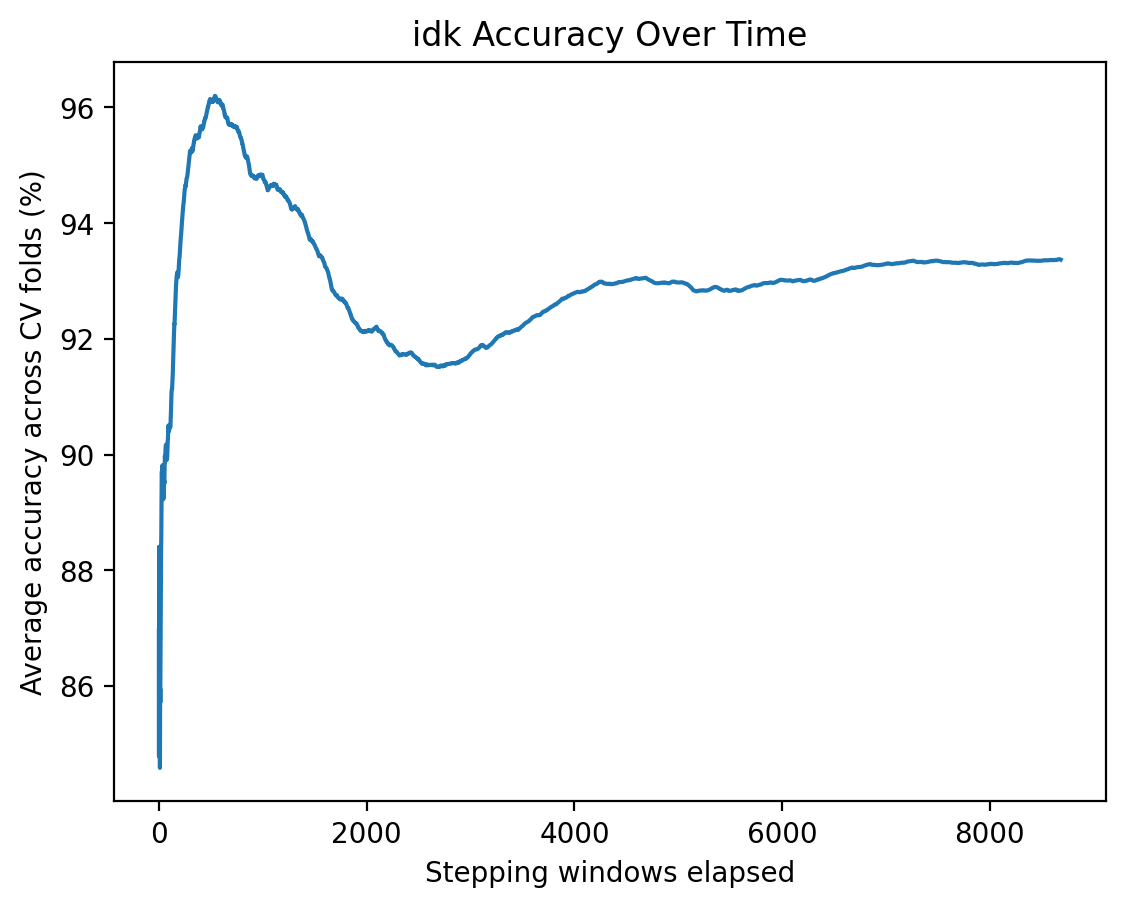

The best parameters were (('max_depth', 30), ('n_estimators', 300))
Accuracy for each fold: [0.9148974943052391, 0.9438943894389439, 0.9936708860759493, 0.9440546356066984, 0.9973206062128444, 0.9575710393149085, 0.8730668658946582, 0.9956379498364231, 0.9450337512054002, 0.9245399313198908, 0.9778359130877117, 0.9881377404122998, 0.8655968632006971, 0.9035222052067381, 0.7178856382978723, 0.9953178206583428, 0.9896669231614819, 0.9795597484276729, 0.7404879367439345, 0.9717255351008544, 0.9938044662309368, 0.9731280193236715, 0.9974431435876733]
Mean accuracy: 0.9384260653326454
Std accuracy: 0.07519980834829922
Sensitivity for each fold: [0.9141302342741192, 0.9719697613182706, 0.9964095199015183, 0.9412658227848101, 0.9976325757575758, 0.9550111039472742, 0.8735532407407407, 0.9978098992553658, 0.9482370592648162, 0.9243637017717421, 0.544, 0.9953325554259043, 0.7580971659919028, nan, nan, 0.9921760391198045, 0.9905469277515192, 0.9952587909917029, 0.6653021269021981, 0.994695898161

In [28]:
score_reporter(results, False, True)

In [29]:
# AdaBoost
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "n_estimators": [300]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = AdaBoostClassifier(algorithm="SAMME.R",
                                **fit_params)
        fold_results = Parallel(n_jobs=4)(
            delayed(fit_xgboost_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)
            for (train, test) in splits
        )
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_feature_importances"] = result["feature_importances"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_stepping_{current_weight}/ada_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

(('n_estimators', 300),) 0.9279921335600001


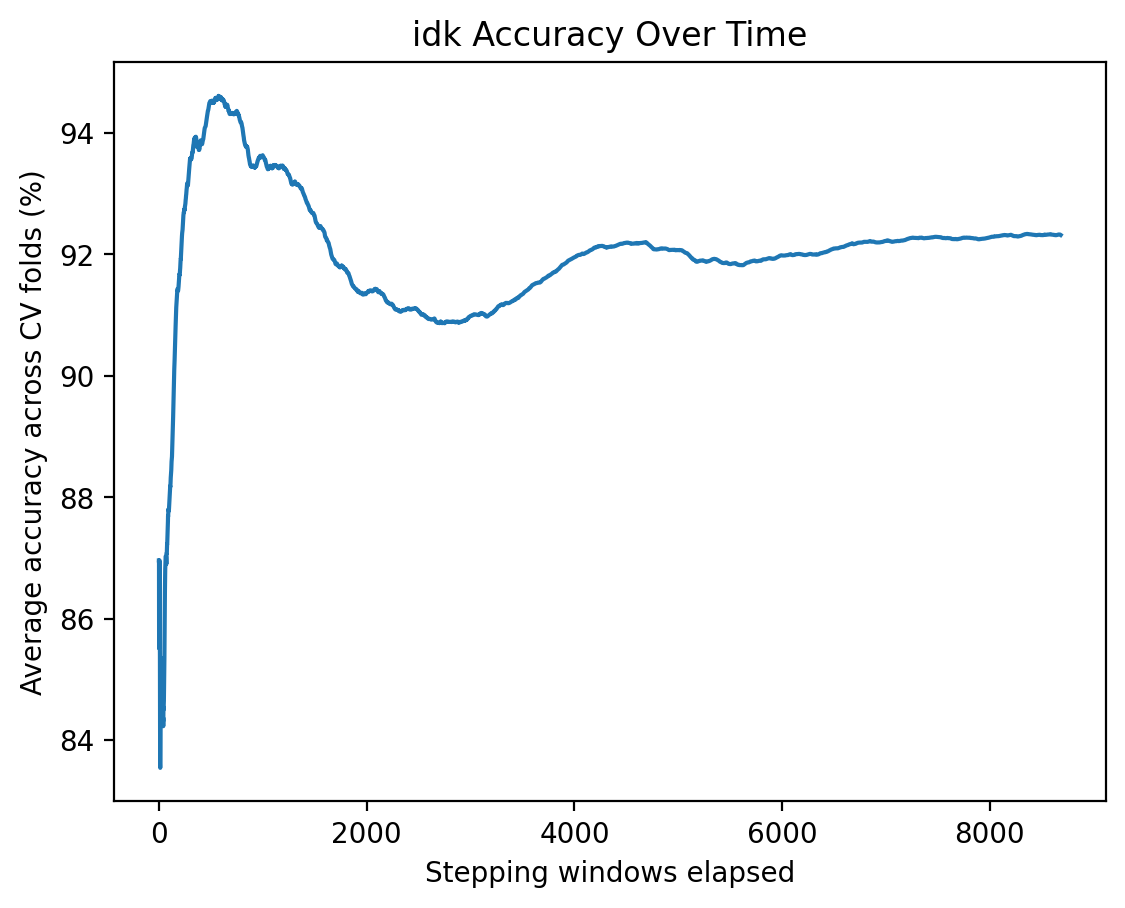

The best parameters were (('n_estimators', 300),)
Accuracy for each fold: [0.9130751708428246, 0.943700252378179, 0.9933694996986137, 0.9182336981944055, 0.9946412124256887, 0.9476449980537174, 0.8779230481882705, 0.9941112322791712, 0.9324172291867566, 0.9380998503125826, 0.9743477944916794, 0.9885984106875504, 0.8480975893116468, 0.8826952526799388, 0.5927526595744681, 0.9860953461975028, 0.9864790590304496, 0.9772475027746947, 0.7153477056160032, 0.9708447106491677, 0.9849537037037037, 0.9887278582930756, 0.9944152873099179]
Mean accuracy: 0.9279921335600001
Std accuracy: 0.09576513674968083
Sensitivity for each fold: [0.9122855561704483, 0.9673829949885331, 0.9954862535904802, 0.913012658227848, 0.9971590909090909, 0.9430474962389856, 0.8738425925925926, 0.9959483136224266, 0.9422355588897224, 0.9381239320082742, 0.522, 0.9933488914819136, 0.7313475997686524, nan, nan, 0.9706601466992665, 0.987575962187711, 0.9952587909917029, 0.6337990566877281, 0.991041961338991, 0.99677891654465

In [30]:
score_reporter(results, False, True)

In [31]:
'''
# Gradient Boost
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "n_estimators": [350]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = GradientBoostingClassifier(loss="log_loss",
                                         max_depth=8,
                                            **fit_params)
        fold_results = Parallel(n_jobs=4)(
            delayed(fit_xgboost_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)
            for (train, test) in splits
        )
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_feature_importances"] = result["feature_importances"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_stepping_{current_weight}/gb_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

'\n# Gradient Boost\nfolder = \'./joblib_memmap\'\ntry:\n    os.mkdir(folder)\nexcept FileExistsError:\n    pass\n\ndump(X, os.path.join(folder, \'X\'))\nX_memmap = load(os.path.join(folder, \'X\'), mmap_mode=\'r\')\ndump(y, os.path.join(folder, \'y\'))\ny_memmap = load(os.path.join(folder, \'y\'), mmap_mode=\'r\')\n\n#num_combinations = 30\nparams = {\n    "n_estimators": [350]\n}\nparam_grid = ParameterGrid(params)\nprint(f\'Fitting with {len(param_grid)} different parameter combinations\')\nresults = {}\n\nwith tqdm(param_grid) as pbar:\n    for fit_params in pbar:\n        pbar.set_description(f\'Fitting parameter combination: {fit_params}\')\n        \n        clf = GradientBoostingClassifier(loss="log_loss",\n                                         max_depth=8,\n                                            **fit_params)\n        fold_results = Parallel(n_jobs=4)(\n            delayed(fit_xgboost_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)\n            for (train

In [32]:
# score_reporter(results)

In [33]:
# SVC
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    #"kernel": ["linear", "rbf"]
    "verbose": [False]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = LinearSVC(**fit_params)
        
        fold_results = []
        for (train, test) in tqdm(splits, leave=False):
            X_train = X.iloc[train]
            y_train = y.iloc[train]

            X_test = X.iloc[test]
            y_test = y.iloc[test]

            cloned_clf = clone(clf)
            cloned_clf.fit(X_train, y_train)

            pred_values = cloned_clf.predict(X_test)
    
            total_seen = 0
            total_correct = 0
            subject_acc = []
            for idx, pred in enumerate(pred_values):
                total_seen+=1
                if pred==y_test.iloc[idx]:
                    total_correct+=1
                subject_acc.append(total_correct/total_seen)

            cm = confusion_matrix(y_test.values.reshape(y_test.shape[0]), pred_values)
            sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
            specificity = cm[1][1]/(cm[1][0]+cm[1][1])
            precision = (cm[0][0])/(cm[0][0]+cm[1][0])

            results_dict = {
                "accuracy": accuracy_score(y_test, pred_values),
                "sensitivity": sensitivity,
                "specificity": specificity,
                "precision": precision,
                "f1_score": (2*precision*sensitivity)/(precision+sensitivity),
                "subject_acc": subject_acc
            }

            fold_results.append(results_dict)
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_stepping_{current_weight}/svc_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

/Users/taran/opt/anaconda3/envs/afib/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/taran/opt/anaconda3/envs/afib/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/taran/opt/anaconda3/envs/afib/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/taran/opt/anaconda3/envs/afib/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/taran/opt/anaconda3/envs/afib/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/taran/opt/anaconda

(('verbose', False),) 0.8321295344594365


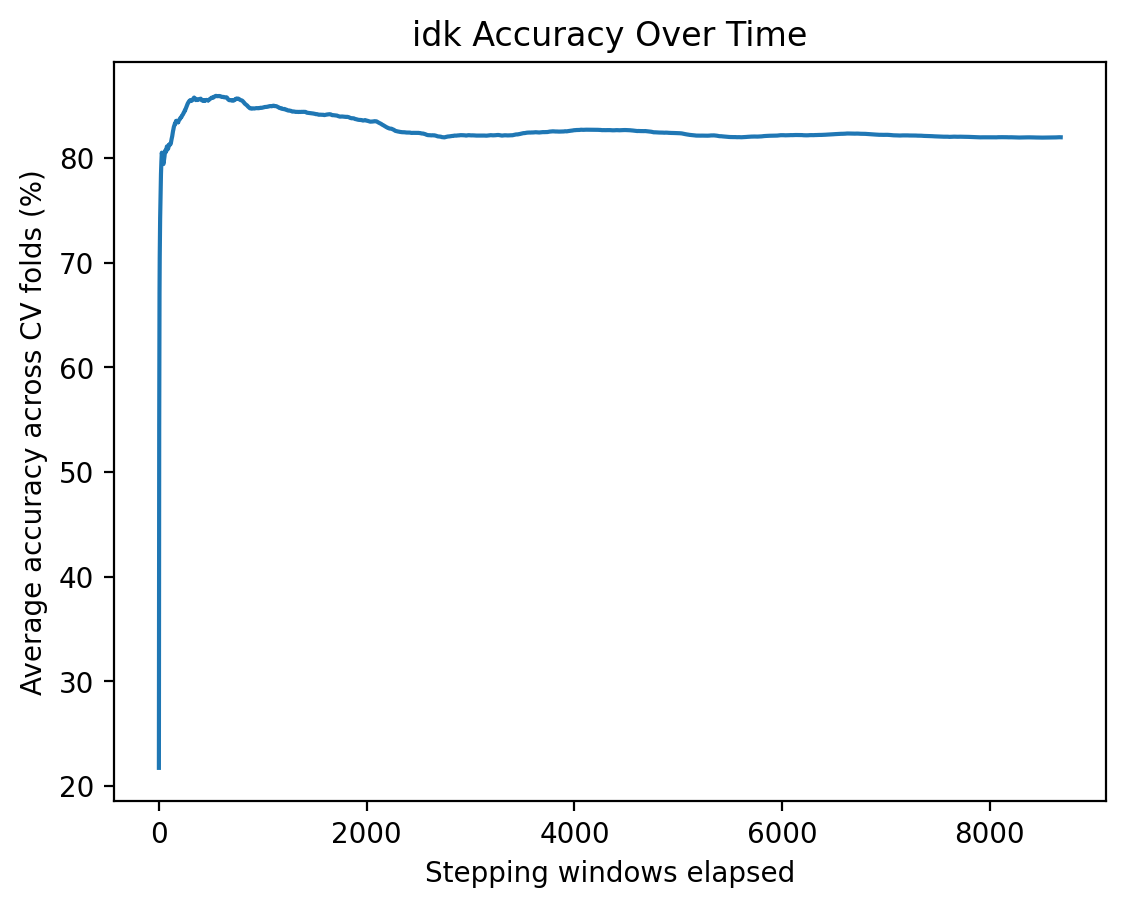

The best parameters were (('verbose', False),)
Accuracy for each fold: [0.8908428246013668, 0.9435708276710024, 0.9953787422141852, 0.9335765740480868, 0.7277903374361551, 0.9322693655118723, 0.8918192005976839, 0.9957470010905125, 0.9257473481195757, 0.9310557365501453, 0.04200276142722186, 0.9910169296326155, 0.6132006970665118, 0.27514037774374683, 0.8023271276595745, 0.9585698070374574, 0.9776849510827745, 0.9886237513873474, 0.4477934716496587, 0.9676737426230952, 0.917619825708061, 0.9913446054750402, 0.9981832862333468]
Mean accuracy: 0.8321295344594365
Std accuracy: 0.248402708992097
Sensitivity for each fold: [0.8896882494004796, 0.934511169625414, 0.9975379565038982, 0.929620253164557, 0.9997632575757576, 0.926642309621033, 0.7653356481481481, 0.9998904949627683, 0.8672168042010503, 0.9311988488173397, 1.0, 0.9948658109684948, 0.23987854251012145, nan, nan, 0.9393643031784841, 0.9908170155300473, 0.9897273804820229, 0.27436148438195246, 0.9586280056577087, 0.9792093704245973,

In [34]:
score_reporter(results, False, True)

In [35]:
# XGBoost
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "n_estimators": [1050],
    "max_depth": [5]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = XGBClassifier(learning_rate = 0.1,
                        verbose=None, 
                        eval_metric='logloss',
                        tree_method='hist',
                        **fit_params)
        fold_results = Parallel(n_jobs=8)(
            delayed(fit_xgboost_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)
            for (train, test) in splits
        )
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_feature_importances"] = result["feature_importances"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_stepping_{current_weight}/xg_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

(('max_depth', 5), ('n_estimators', 1050)) 0.9504951461432575


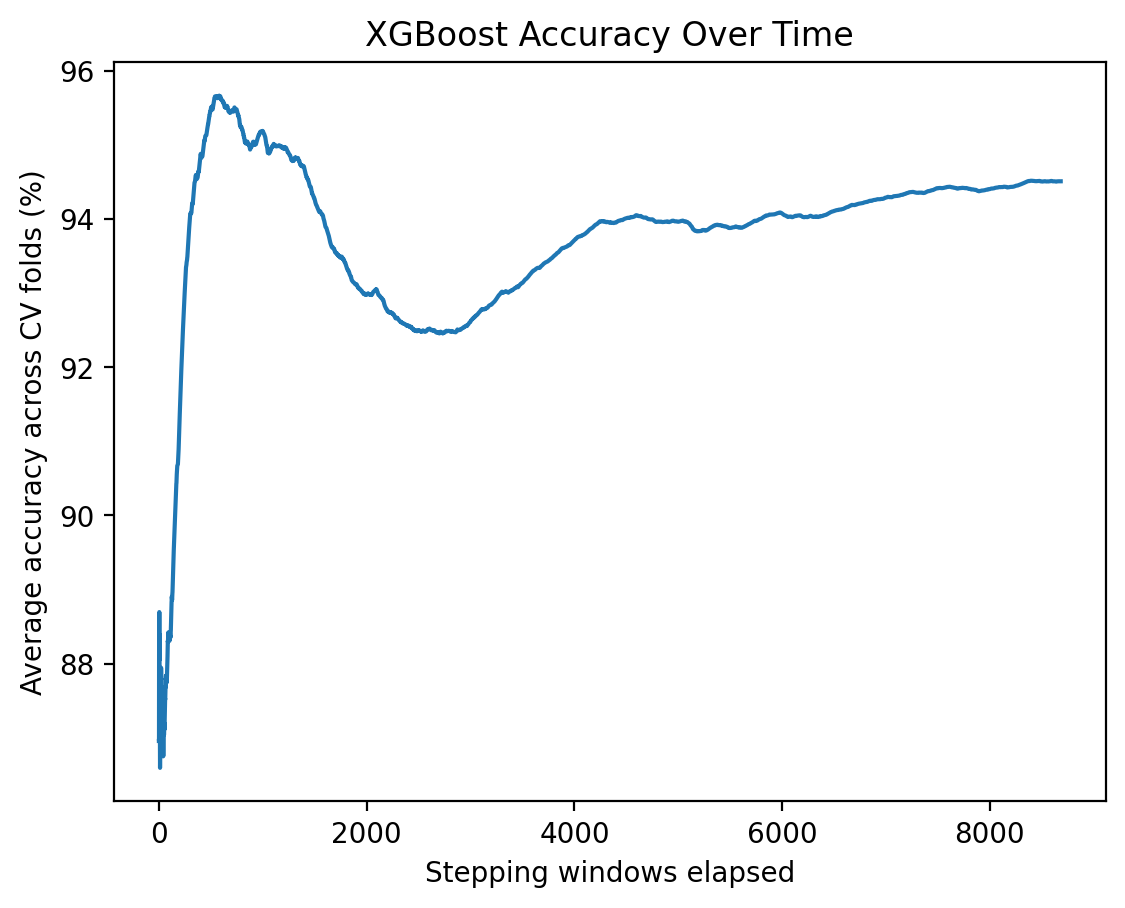

The best parameters were (('max_depth', 5), ('n_estimators', 1050))
Accuracy for each fold: [0.9162642369020502, 0.9466123082896525, 0.9929676511954993, 0.9390027130695107, 0.9961483714309638, 0.9745685740236149, 0.8759805752708255, 0.9965103598691385, 0.9486499517839923, 0.9333450735229374, 0.9794346341108932, 0.9892894161004261, 0.902555910543131, 0.9227156712608474, 0.8193484042553192, 0.9913450624290578, 0.9896669231614819, 0.9879763226045135, 0.806312090288572, 0.9838809125341319, 0.9904003267973857, 0.9839975845410628, 0.9944152873099179]
Mean accuracy: 0.9504951461432575
Std accuracy: 0.05418202287149248
Sensitivity for each fold: [0.9155137428518724, 0.9723944619043574, 0.9975379565038982, 0.9362025316455697, 0.9981060606060606, 0.9737803567590801, 0.8822337962962963, 0.9987954445904511, 0.951487871967992, 0.9340768054681177, 0.574, 0.9970828471411902, 0.824465008675535, nan, nan, 0.9995110024449878, 0.9904118838622552, 0.9976293954958514, 0.7519800658538756, 0.9965818010372466

In [36]:
score_reporter(results, True, True, "XGBoost")

In [37]:
# CatBoost
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 15
params = {
    "n_estimators": [650],
    "max_depth": [6]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = CatBoostClassifier(
                        learning_rate=0.1,
                        loss_function='Logloss',
                        task_type="CPU",
                        silent=True,
                        **fit_params)
        fold_results = Parallel(n_jobs=1)(
            delayed(fit_catboost_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)
            for (train, test) in splits
        )
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_feature_importances"] = result["feature_importances"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_stepping_{current_weight}/cb_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

(('max_depth', 6), ('n_estimators', 650)) 0.9501529191164874


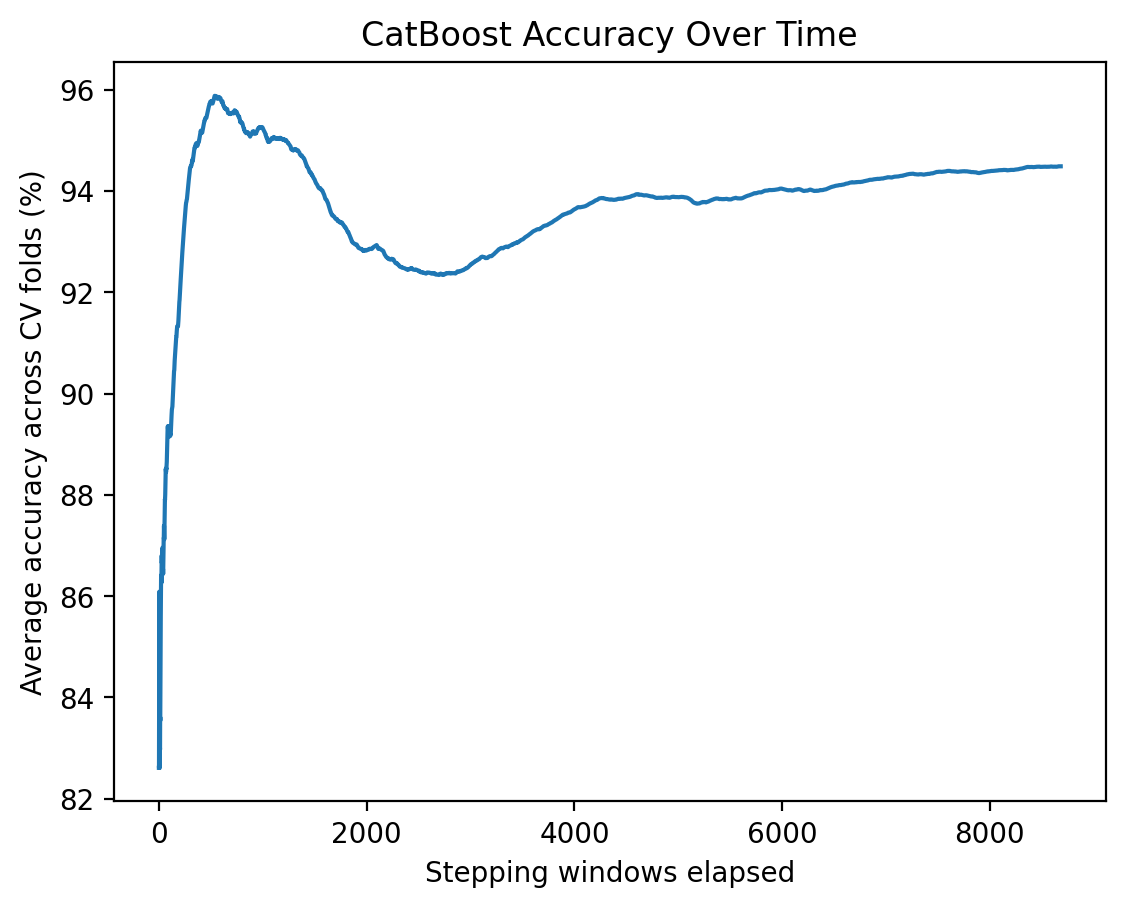

The best parameters were (('max_depth', 6), ('n_estimators', 650))
Accuracy for each fold: [0.9161731207289294, 0.9471300071183589, 0.9928671890697207, 0.9403124707643372, 0.9967344888219041, 0.9742441935902426, 0.8909973851326112, 0.9960741548527808, 0.9505785920925748, 0.9327287135687241, 0.9784899353244677, 0.9907865944949902, 0.9098896311356375, 0.9264931087289433, 0.7878989361702128, 0.9939699205448355, 0.9886775860173683, 0.989086200517943, 0.8017165641684125, 0.9836166651986259, 0.9901279956427015, 0.9805756843800322, 0.9943480016148567]
Mean accuracy: 0.9501529191164874
Std accuracy: 0.05720232126332571
Sensitivity for each fold: [0.9154215089466888, 0.9688269769812282, 0.9970250307755437, 0.9371139240506329, 0.9981060606060606, 0.9734938032810373, 0.8949652777777778, 0.9983574244415243, 0.9489872468117029, 0.9331774440147496, 0.576, 0.9977829638273046, 0.8392134181607865, nan, nan, 0.9985330073349633, 0.9898717083051992, 0.9976293954958514, 0.7452166948473792, 0.99575671852899

In [38]:
score_reporter(results, False, True, "CatBoost")

In [39]:
# LightGBM
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 15
params = {
    "n_estimators": [1000],
    "max_depth": [5]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = lightgbm.LGBMClassifier(
                        learning_rate=0.1,
                        device="cpu",
                        verbose=-1,
                        **fit_params)
        fold_results = []
        for (train, test) in tqdm(splits, leave=False):
            X_train = X.iloc[train]
            y_train = y.iloc[train]

            X_test = X.iloc[test]
            y_test = y.iloc[test]

            cloned_clf = clone(clf)
            cloned_clf.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)], 
                   eval_metric='logloss')

            pred_values = cloned_clf.predict(X_test)
    
            total_seen = 0
            total_correct = 0
            subject_acc = []
            for idx, pred in enumerate(pred_values):
                total_seen+=1
                if pred==y_test.iloc[idx]:
                    total_correct+=1
                subject_acc.append(total_correct/total_seen)

            cm = confusion_matrix(y_test.values.reshape(y_test.shape[0]), pred_values)
            sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
            specificity = cm[1][1]/(cm[1][0]+cm[1][1])
            precision = (cm[0][0])/(cm[0][0]+cm[1][0])

            results_dict = {
                "accuracy": accuracy_score(y_test, pred_values),
                "sensitivity": sensitivity,
                "specificity": specificity,
                "precision": precision,
                "f1_score": (2*precision*sensitivity)/(precision+sensitivity),
                "feature_importances": {A: B for A, B in zip(cloned_clf.feature_name_, cloned_clf.feature_importances_)}, 
                "subject_acc": subject_acc
            }

            fold_results.append(results_dict)
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_feature_importances"] = result["feature_importances"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_stepping_{current_weight}/lg_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

[1]	training's binary_logloss: 0.61372	valid_0's binary_logloss: 0.569762
[2]	training's binary_logloss: 0.550112	valid_0's binary_logloss: 0.517125
[3]	training's binary_logloss: 0.496959	valid_0's binary_logloss: 0.47394
[4]	training's binary_logloss: 0.451959	valid_0's binary_logloss: 0.438302
[5]	training's binary_logloss: 0.413326	valid_0's binary_logloss: 0.408055
[6]	training's binary_logloss: 0.380146	valid_0's binary_logloss: 0.383002
[7]	training's binary_logloss: 0.351021	valid_0's binary_logloss: 0.362564
[8]	training's binary_logloss: 0.325786	valid_0's binary_logloss: 0.344467
[9]	training's binary_logloss: 0.303256	valid_0's binary_logloss: 0.329269
[10]	training's binary_logloss: 0.283742	valid_0's binary_logloss: 0.316681
[11]	training's binary_logloss: 0.266418	valid_0's binary_logloss: 0.305688
[12]	training's binary_logloss: 0.250983	valid_0's binary_logloss: 0.296518
[13]	training's binary_logloss: 0.237355	valid_0's binary_logloss: 0.289004
[14]	training's binary_

(('max_depth', 5), ('n_estimators', 1000)) 0.9493479286880802


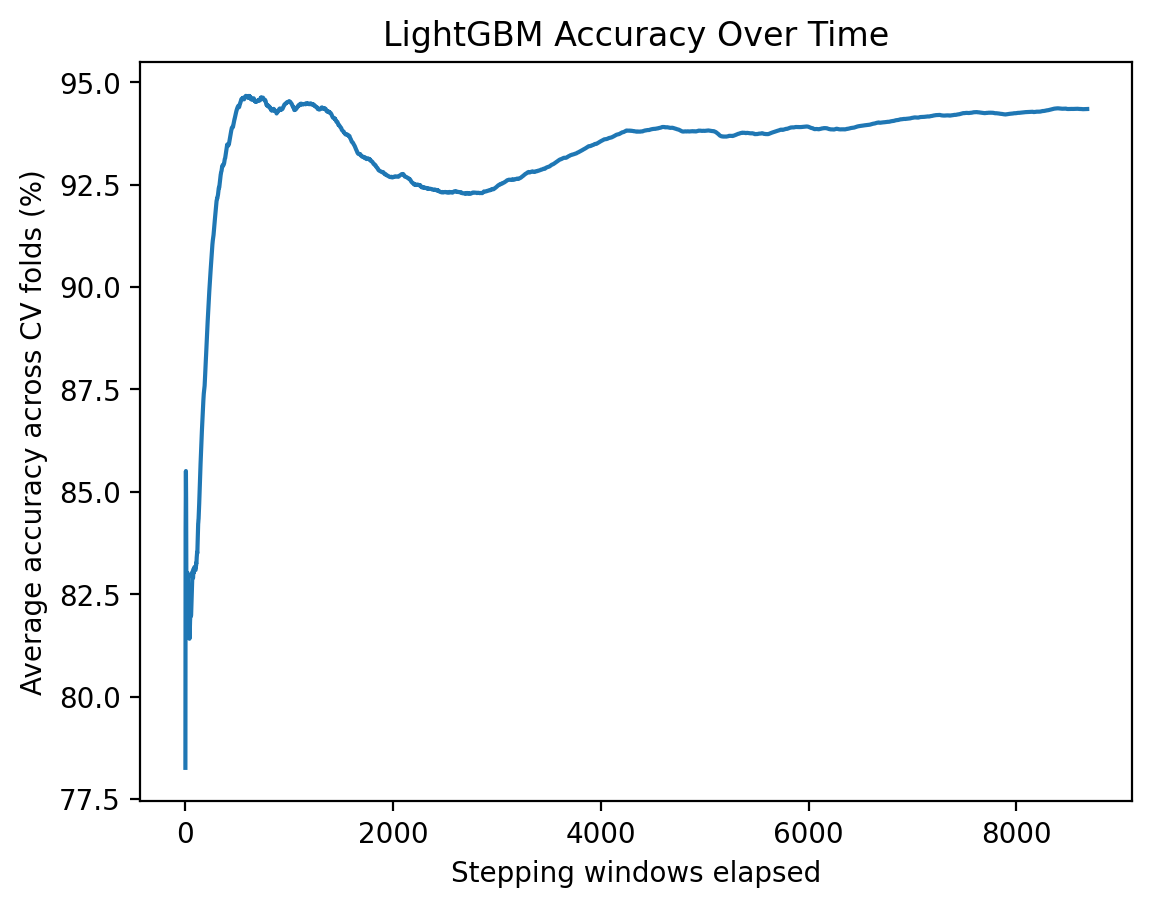

The best parameters were (('max_depth', 5), ('n_estimators', 1000))
Accuracy for each fold: [0.9161731207289294, 0.9464828835824759, 0.9921639541892706, 0.9365703059219759, 0.9962321024868124, 0.9734656805501493, 0.8750840493089279, 0.9967284623773174, 0.9487303117968499, 0.9366910275600951, 0.9770365525761209, 0.9890590809628009, 0.900014522218995, 0.9172026544155181, 0.8113031914893617, 0.9905646992054483, 0.9897768495108278, 0.9855715871254163, 0.8037440021626006, 0.9830881705276139, 0.9905364923747276, 0.9840982286634461, 0.9946844300901628]
Mean accuracy: 0.9493479286880802
Std accuracy: 0.055410175569235234
Sensitivity for each fold: [0.9153292750415053, 0.9731589229593137, 0.9974353713582274, 0.9350886075949367, 0.9978693181818182, 0.9724908661078874, 0.8813657407407407, 0.9987954445904511, 0.9519879969992499, 0.9374943789909165, 0.58, 0.9968494749124854, 0.824465008675535, nan, nan, 0.9990220048899755, 0.9909520594193113, 0.99723429474516, 0.7490433389694758, 0.9961103253182461

In [40]:
score_reporter(results, False, True, "LightGBM")